In [15]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

In [16]:
model_path = r"C:\Users\Ekaansh\OneDrive\Desktop\AB\research\SHAP\best_pneumonia_densenet121.pt"
class_names = ['NORMAL', 'PNEUMONIA']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
model = models.densenet121(weights=None)
num_features = model.classifier.in_features

In [26]:
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(class_names))
)

In [27]:
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

C:\Users\Ekaansh\AppData\Local\Temp\ipykernel_27780\4197081692.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [28]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [29]:
def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        label = class_names[pred_idx]
        confidence = probs[0][pred_idx].item()

    print(f"Predicted: {label} ({confidence*100:.2f}%)")

In [31]:
predict_image(r"D:\datasets\chest_xray\val\PNEUMONIA\person1946_bacteria_4875.jpeg")


Predicted: PNEUMONIA (99.66%)


In [49]:
import shap
import numpy as np 

In [50]:
def preprocess_image(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)

In [51]:
image_path = r"D:\datasets\chest_xray\val\PNEUMONIA\person1946_bacteria_4875.jpeg"
input_tensor = preprocess_image(image_path)

In [52]:
background = torch.zeros((1, 3, 224, 224)).to(device)

In [53]:
explainer = shap.GradientExplainer(model, background)

In [54]:
shap_values = explainer.shap_values(input_tensor)

In [55]:
img_np = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()  # HWC
img_np = np.expand_dims(img_np, axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9254032].


TypeError: Invalid shape (3, 224, 224) for image data

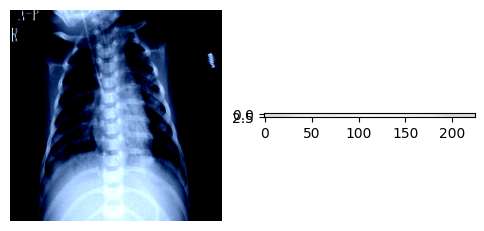

In [56]:
shap.image_plot(shap_values, img_np)